# Analisis Sentimen Ulasan Pariwisata Bali

## 1. Import Library

In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense


## 2. Data Loading

In [ ]:
monkey_forest_df = pd.read_csv("./data/monkey_forest_reviews.csv")
tanah_lot_df = pd.read_csv("./data/tanah_lot_reviews.csv")
uluwatu_df = pd.read_csv("./data/uluwatu_reviews.csv")

monkey_forest_df["destination"] = "Monkey Forest"
tanah_lot_df["destination"] = "Tanah Lot"
uluwatu_df["destination"] = "Uluwatu"

combined_df = pd.concat([monkey_forest_df, tanah_lot_df, uluwatu_df], ignore_index=True)
combined_df.to_csv("./data/all_reviews_combined.csv", index=False)
df = combined_df
print(df.head())

                user  rating                               review  \
0         Rossella D       4                 The tip for all ages   
1  Escape42508350609       1        The child attacked and bitten   
2   AndySouthland_NZ       5                              Amazing   
3            Marie R       5                        Exursion ubud   
4            James E       4  Enjoyed the walk and the experience   

                 date  year    destination  
0   Apr 2025 • Family  2025  Monkey Forest  
1   Apr 2025 • Family  2025  Monkey Forest  
2  Apr 2025 • Couples  2025  Monkey Forest  
3  Apr 2025 • Friends  2025  Monkey Forest  
4   Apr 2025 • Family  2025  Monkey Forest  


## 3. Data Cleaning

In [14]:
def clean_text(text):
    text = str(text).lower()                           
    text = re.sub(r'http\S+', '', text)                
    text = re.sub(r'[^a-z\s]', '', text)               
    text = re.sub(r'\s+', ' ', text).strip()           
    return text

df["clean_review"] = df["review"].apply(clean_text)
print(df["clean_review"].head())


0                   the tip for all ages
1          the child attacked and bitten
2                                amazing
3                          exursion ubud
4    enjoyed the walk and the experience
Name: clean_review, dtype: object


## 4. Pelabelan Sentimen

In [15]:
def label_sentiment(rating):
    if rating <= 2:
        return 0  # Negatif
    elif rating == 3:
        return 1  # Netral
    else:
        return 2  # Positif

df["sentiment"] = df["rating"].apply(label_sentiment)
print(df["sentiment"].value_counts())

2    279
0     17
1     14
Name: sentiment, dtype: int64


## 5. Data Splitting

In [ ]:

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_review"])
sequences = tokenizer.texts_to_sequences(df["clean_review"])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(
    padded, df["sentiment"], test_size=0.2, random_state=42
)

## 6. Modelling

In [ ]:

model = Sequential([
    Embedding(input_dim=10000, output_dim=16, input_length=100),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 7. Evaluasi Model

In [ ]:

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
8/8 [==============================] - 1s 25ms/step - loss: 1.0486 - accuracy: 0.9153 - val_loss: 1.0302 - val_accuracy: 0.8387
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 1.0059 - accuracy: 0.9153 - val_loss: 0.9893 - val_accuracy: 0.8387
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.9596 - accuracy: 0.9153 - val_loss: 0.9468 - val_accuracy: 0.8387
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 0.9106 - accuracy: 0.9153 - val_loss: 0.9019 - val_accuracy: 0.8387
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.8593 - accuracy: 0.9153 - val_loss: 0.8545 - val_accuracy: 0.8387
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.8039 - accuracy: 0.9153 - val_loss: 0.8060 - val_accuracy: 0.8387
Epoch 7/10
8/8 [==============================] - 0s 5ms/step - loss: 0.7463 - accuracy: 0.9153 - val_loss: 0.7578 - val_accuracy: 0.8387
Epoch 8/10
8/8 [=================

## 8. Visualisasi Data

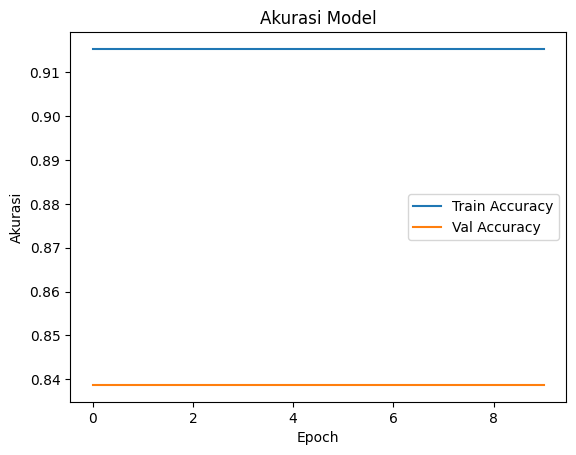

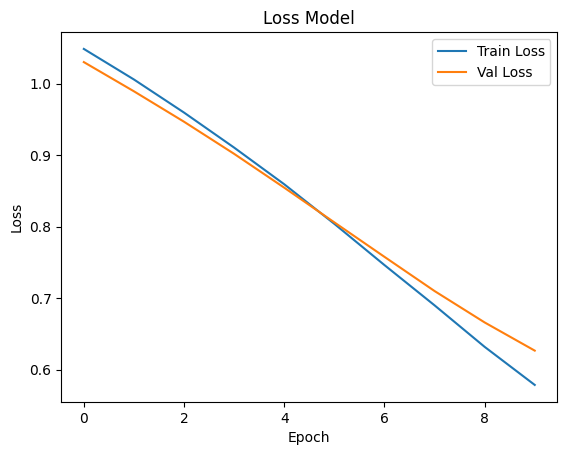

In [ ]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step


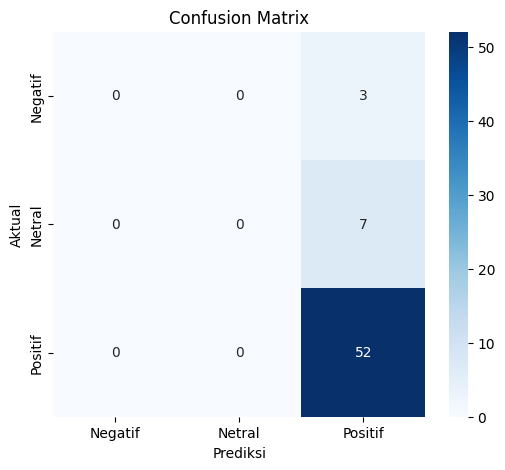

              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         3
      Netral       0.00      0.00      0.00         7
     Positif       0.84      1.00      0.91        52

    accuracy                           0.84        62
   macro avg       0.28      0.33      0.30        62
weighted avg       0.70      0.84      0.77        62



c:\Users\Asus\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()


print(classification_report(y_test, y_pred, target_names=['Negatif', 'Netral', 'Positif']))

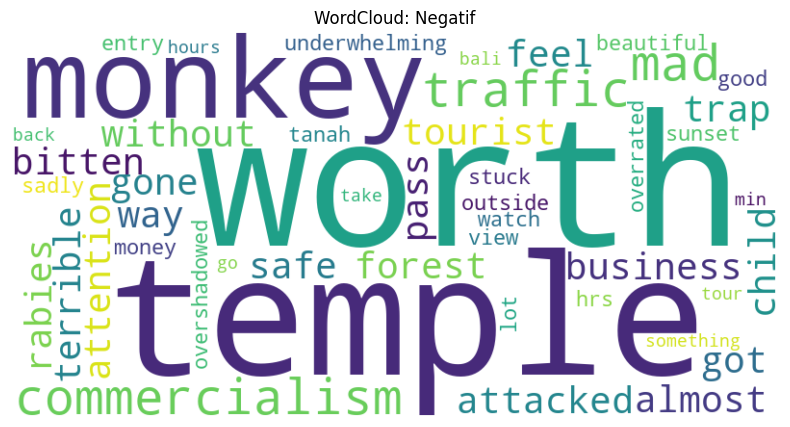

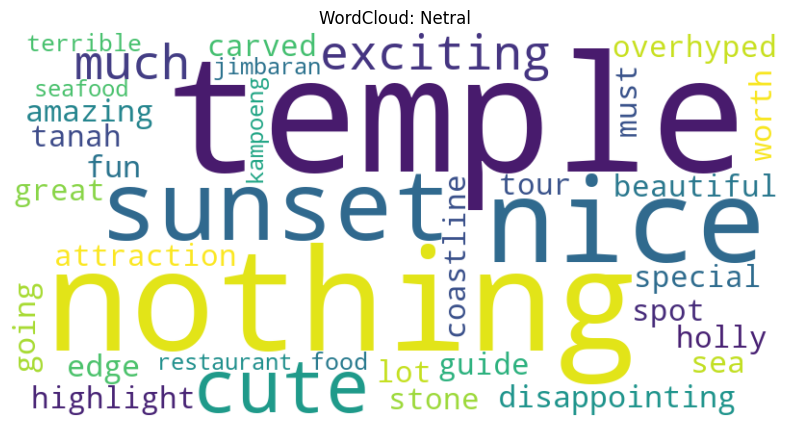

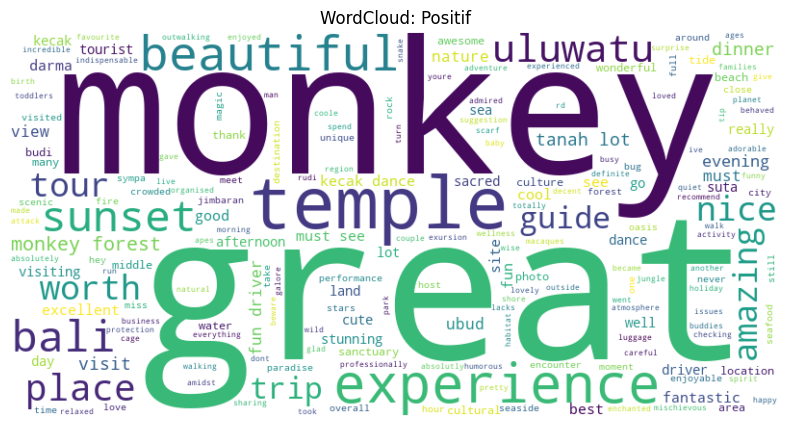

In [ ]:
for label, name in zip([0, 1, 2], ['Negatif', 'Netral', 'Positif']):
    text = " ".join(df[df["sentiment"] == label]["clean_review"])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud: {name}")
    plt.show()

## 9. Konversi Model